In [366]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import time
import datetime
import seaborn as sns
import pandas as pd
import time
import markdown
savedate = str(datetime.datetime.now())
t = time.time()
# Disable certain pandas warning
pd.options.mode.chained_assignment = None  # default='warn'

# Simulation

Bayesian update of braking force expected value for known $\sigma$ according to:

\begin{equation} E(\mu' | x) = \frac{\sigma^2 \mu + \sigma_0^2 x}{\sigma^2 + \sigma_0^2} \end{equation}

\begin{equation} Var(\mu' | x) = \frac{\sigma \sigma_0}{\sigma^2 + \sigma_0^2} \end{equation}

As an addition, an alertness factor reflecting the variation introduced by the train sets, is used.

In [405]:
%%time
np.random.seed(42)
# Train data
NWagonsFleet = 100
NWagonsTrain = 20
M = 100 #Trains assembled
N = 10 #Brakings observed per Train

# Faulty wagon number and associated brake force percentage
nfault = []
pfault = 0

# Wagon data 
# Mass full loaded
mass = 90000
# Brake pad friction
mu = 0.20
# Brake rigging efficiency
eta = 0.81
# Nominal pad braking force
bfNom = 4.8800000e+05
# Resulting retardation force
rBF = bfNom*eta*mu
# Standard deviation of retardation force
sdBF = 0.05*rBF
# Measurement noise SD
sdnoisec = 0.1
sdnoise = sdnoisec*rBF
# Alertness factor lambda
alertness = 5

# Populate train fleet
fleet = {'Mass': np.random.uniform(low = .9*mass, high = mass, size = NWagonsFleet),
         'Sigma_true': sdBF*np.ones(NWagonsFleet),
         'Sigma_est': 10*sdBF*np.ones(NWagonsFleet),
         'Sigma_prio': 10*sdBF*np.ones(NWagonsFleet),
         'n': np.zeros(NWagonsFleet)}
Fleet = pd.DataFrame(data = fleet)
Fleet['BF_true'] = np.random.normal(loc = rBF, scale = sdBF, size = NWagonsFleet)
Fleet['BF_est'] = np.random.normal(loc = .5*rBF, scale = sdBF, size = NWagonsFleet)
Fleet['BF_prio'] = Fleet['BF_est']
Train_error = []
Fleet_error = []

if n:
    Fleet.loc[nfault, 'BF_true'] = pfault*Fleet.loc[nfault, 'BF_true']


for i in range(0, M):
    # Build a train, randomly from fleet
    WagonsSelected = np.random.choice(range(0, NWagonsFleet), size =  NWagonsTrain, replace = False)
    Train = Fleet.iloc[WagonsSelected]
    # Brake N times
    for i in range(0, N):
        # Observed Deceleration, each wagon observes identical deceleration
        Train['a_obs'] = Train['BF_true'].sum()/Train['Mass'].sum()*(1+np.random.normal(0, sdnoisec, NWagonsTrain)) # Measurement noise
        # Observed braking force from this deceleration
        Train['BF_obs'] = Train['a_obs']*Train['Mass']
        # Update belief
        Train['Sigma_est'] = alertness*np.sqrt((sdnoise**2*Train['Sigma_est']**2)/(sdnoise**2+Train['Sigma_est']**2))
        Train['BF_est'] = (Fleet['BF_prio']*sdnoise**2+Train['BF_obs']*Train['Sigma_est']**2)/(sdnoise**2+Train['Sigma_est']**2)
        # Save the current error level
        Train_error.append((Train['BF_true'] - Train['BF_est']).mean())
        Fleet_error.append((Fleet['BF_true'] - Fleet['BF_est']).mean() )
        # Swap data to fleet DB
        Fleet.loc[Train.index, 'BF_est'] = Train['BF_est']
        Fleet.loc[Train.index, 'Sigma_est'] = Train['Sigma_est']
        Fleet.loc[Train.index, 'n'] += 1
        #print(Fleet['BF_est'].mean())
error = Fleet['BF_true'] - Fleet['BF_est']
print('RMS: ', np.sqrt((error**2).mean()))

RMS:  8016.49068657
CPU times: user 8.3 s, sys: 55.1 ms, total: 8.36 s
Wall time: 8.46 s


# Plotting

The estimated vs. true braking forces of the fleet are plotted as well as the error on train and fleet level.

AttributeError: 'AxesSubplot' object has no attribute 'ylabel'

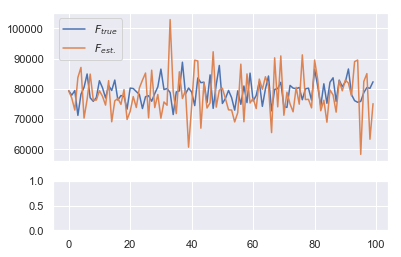

In [417]:
sns.set()
f, axarr = plt.subplots(2, sharex=True, gridspec_kw = {'height_ratios':[3, 1]})
Fleet.plot(kind = 'line', y = 'BF_true', ax = axarr[0], label = '$F_{true}$')
Fleet.plot(kind = 'line', y = 'BF_est', ax = axarr[0], label = '$F_{est.}$')
axarr[0].setylabel('$F$/N')
axarr[0].legend(loc = 1)
axarr[0].set_title('Estimated vs. true $F_b$')
Fleet.plot(kind = 'line', y = 'n', ax = axarr[1], label = '$n$')
axarr[1].legend(loc = 1)
plt.xlabel('Wagon number')

f2, axarr2 = plt.subplots(1)
plt.plot(Train_error, label = '$E_{train}$')
plt.plot(Fleet_error, label = '$E_{fleet}$')
axarr2.legend(loc = 1)
axarr2.set_title('Error on train and fleet level')
mute = plt.xlabel('Iteration')

In [407]:
#Saving data and figure
Fleet.to_json('190119_TrainSim.json')
f.savefig("FleetEstimate.pdf", bbox_inches='tight')
f2.savefig("Errors.pdf", bbox_inches='tight')

In [404]:
Train.head()

,Mass,Sigma_est,Sigma_prio,Sigma_true,n,BF_true,BF_est,BF_prio,a_obs,BF_obs
42,81309.496690,38729.372221,39528.0,3952.8,230.0,83573.350021,89197.649951,37609.454968,1.123450,91347.158075
77,81666.401866,38729.372221,39528.0,3952.8,110.0,79974.052414,76441.805661,43609.128682,0.952777,77809.833869
2,87587.945476,38729.372221,39528.0,3952.8,190.0,79418.711997,72957.519707,38481.864470,0.849364,74394.005342
16,83738.180187,38729.372221,39528.0,3952.8,120.0,76280.924531,76807.658573,40374.269752,0.935364,78325.716441
51,87976.195410,38729.372221,39528.0,3952.8,200.0,76817.538334,76707.992847,35267.890442,0.891544,78434.663781
